The project follows a systematic approach:

• Import and preprocess the dataset, including handling missing values, standardizing numerical features, and encoding categorical variables.\
• Conduct exploratory data analysis (EDA) to understand data distribution and visualize patterns relevant to flight cancellations.\
• Perform feature engineering and split the dataset into training, validation, and test sets (80-10-10).\
• Establish baseline models with logistic regression and decision tree models to provide an initial benchmark for performance.\
• Apply advanced model training using more complex models to improve prediction accuracy.\
• Conduct hyperparameter tuning to optimize model parameters for the best performance.\
• Evaluate the optimized models on the test set to measure real-world prediction accuracy.\
• Analyze feature importance to interpret model results, identifying keyfactors affecting flight cancellations.\
• Compiling findings, methodologies, and future work for the final report.\

## Step-1: Import and preprocess the dataset

- Import the dataset.
- Handle missing values.

#### Importing the dataset.

In [2]:
import pandas as pd
import os

# Check the current working directory
print(os.getcwd())
!ls
# Print the full path before '/app'
full_path = os.getcwd()
print(full_path.split('/app')[0])
# Import the flights.csv file into a pandas DataFrame
df_flights = pd.read_csv('flight_dataset/flights.csv')
print(df_flights.head())

/app
docker-compose.yml  flights_cleaned.csv     requirements.txt
Dockerfile	    project_notebook.ipynb
flight_dataset	    README.md



/tmp/ipykernel_79/2681771179.py:11: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_flights = pd.read_csv('flight_dataset/flights.csv')


   YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4      AS             98      N407AS   
1  2015      1    1            4      AA           2336      N3KUAA   
2  2015      1    1            4      US            840      N171US   
3  2015      1    1            4      AA            258      N3HYAA   
4  2015      1    1            4      AS            135      N527AS   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  ...  ARRIVAL_TIME  \
0            ANC                 SEA                    5  ...         408.0   
1            LAX                 PBI                   10  ...         741.0   
2            SFO                 CLT                   20  ...         811.0   
3            LAX                 MIA                   20  ...         756.0   
4            SEA                 ANC                   25  ...         259.0   

   ARRIVAL_DELAY  DIVERTED  CANCELLED  CANCELLATION_REASON  AIR_SYSTEM_DELAY  \
0          -

In [3]:

AIR_SYSTEM_DELAY_counts = df_flights['AIR_SYSTEM_DELAY'].value_counts()
print(AIR_SYSTEM_DELAY_counts)

print(df_flights['AIR_SYSTEM_DELAY'].isnull().sum())

AIR_SYSTEM_DELAY
0.0      498613
1.0       28003
15.0      23199
2.0       22981
3.0       21446
          ...  
464.0         1
462.0         1
545.0         1
450.0         1
477.0         1
Name: count, Length: 570, dtype: int64
4755640


In [7]:
# Columns not needed or not typically needed
not_needed_columns = [
    "YEAR",            # All 2015
    "FLIGHT_NUMBER",   # Unique to each flight, doesn't generalize well for predictions.
    "TAIL_NUMBER",     # Unique identifier for aircraft, unlikely to contribute to predictions.
    "WHEELS_OFF",      # Redundant; its effect is captured in departure delay and time.
    "WHEELS_ON"        # Redundant; its effect is captured in arrival delay and time.
]
df_flights.drop(columns=not_needed_columns, inplace=True)

#### exploring the dataset types and columns and null values

In [15]:
def explore_the_df(df):
    print(df.shape)
    print(df.info())

    null_counts = df.isnull().sum()
    # Calculate the percentage of null values
    null_percentage = [(x / len(df) * 100) for x in null_counts]

    # Combine the counts and percentages into a single DataFrame
    null_summary = pd.DataFrame({'Null Count': null_counts, 'Percentage': null_percentage})
    print(null_summary)

In [ ]:
#explore_the_df(df_flights)


(5819079, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED          

EDA on cancellation reason

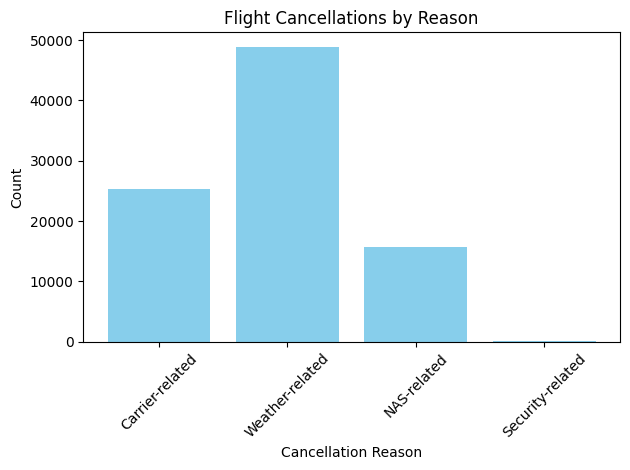

In [ ]:
import matplotlib.pyplot as plt

reason_counts = {"A": 25262, "B": 48851, "C": 15749, "D": 22}

# Mapping codes to full descriptions
reason_mapping = {
    "A": "Carrier-related",
    "B": "Weather-related",
    "C": "NAS-related",
    "D": "Security-related"
}

# Extract data for plotting
codes = list(reason_counts.keys())
counts = list(reason_counts.values())

# Replace codes with full descriptions for x-axis
descriptions = [reason_mapping[code] for code in codes]

# Plot the bar chart
plt.bar(descriptions, counts, color="skyblue")
plt.title("Flight Cancellations by Reason")
plt.xlabel("Cancellation Reason")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

As the last 5 columns have more than 80% null values, we decide to drop those

for cancelled flights, arrival delay is null, all kinds of delays are null, all 5 types of delay are all null. They have entries as number of minutes for other flights which has not been cancelled.

In [22]:
# selected_columns = df_flights[df_flights["CANCELLED"] == 1][["FLIGHT_NUMBER", "AIRLINE", "DISTANCE", "DEPARTURE_DELAY", "ARRIVAL_DELAY", 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']]
# print(selected_columns)


selected_columns = df_flights[( df_flights["CANCELLED"] == 1)]
print(selected_columns['AIR_SYSTEM_DELAY'].head(25))
# print(df_flights['CANCELLED'].value_counts())
# print(selected_columns['CANCELLED'].value_counts())
#AIR_SYSTEM_DELAY        = df_flights['AIR_SYSTEM_DELAY'].value_counts()

32    NaN
42    NaN
68    NaN
82    NaN
90    NaN
128   NaN
131   NaN
147   NaN
166   NaN
206   NaN
210   NaN
213   NaN
214   NaN
265   NaN
297   NaN
298   NaN
306   NaN
307   NaN
308   NaN
309   NaN
310   NaN
311   NaN
312   NaN
313   NaN
314   NaN
Name: AIR_SYSTEM_DELAY, dtype: float64


In [ ]:
# List of columns to drop
# columns_to_drop = ['CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']

# # Drop the columns from the dataframe
# df_flights2 = df_flights.drop(columns=columns_to_drop)


We found that if we drop 105071 rows, we get a dataset without any null or nan values. As 105071 is just 1.8% of the main dataset, so we decided to drop these rows. After dropping these, the new shape is (5714008, 25)

In [22]:
# Drop rows with any null values from df_flights2
df_flights3= df_flights2.dropna()

# Print the shape of the new dataframe to confirm the rows have been dropped
explore_the_df(df_flights3)

(5714008, 25)
<class 'pandas.core.frame.DataFrame'>
Index: 5714008 entries, 0 to 5819078
Data columns (total 25 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             in

In [26]:
df_flights3.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0


## Step-2: make changes to columns, encode, standardize and add engineered columns.


saving the cleaned df in a csv file

In [ ]:
df_flights3.to_csv('flights_cleaned.csv', index=False)

#df_flights3.to_csv('C:/Users/fsani/OneDrive/Desktop/ML_projec_5232/flight_dataset/flights_cleaned.csv', index=False)

In [ ]:
cancelled_counts = df_flights3['CANCELLED'].value_counts()
print(cancelled_counts)


cancelled_counts = df_flights2['CANCELLED'].value_counts()
print(cancelled_counts)


cancelled_counts = df_flights['CANCELLED'].value_counts()
print(cancelled_counts)



CANCELLED
0    5714008
Name: count, dtype: int64
CANCELLED
0    5729195
1      89884
Name: count, dtype: int64
CANCELLED
0    5729195
1      89884
Name: count, dtype: int64


In [ ]:
# Columns to One-Hot Encode
one_hot_encoded_columns = [
    "MONTH",                # Categorical with a fixed range of months (1-12). rechecccccccck
    "DAY_OF_WEEK",          # Categorical with a fixed range of weekdays (1-7). rechecccccccck
    "AIRLINE",              # Categorical; airline carrier codes. 
    "ORIGIN_AIRPORT",       # Categorical; origin airport codes.
    "DESTINATION_AIRPORT",  # Categorical; destination airport codes.
    "CANCELLATION_REASON"   # Categorical; reason for cancellation (A, B, C, D).
]

# Columns to Label Encode
label_encoded_columns = [
    # None for this dataset; all suggested encodings are one-hot for categorical data.
    # You can modify this list if additional categorical columns need ordinal treatment.
]

# Columns to Standardize
standardized_columns = [
    "DEPARTURE_DELAY",      # Continuous; delays in minutes. # contrains negative values as well. Need to rechecccccccck
    "TAXI_OUT",             # Continuous; taxiing time in minutes.
    "SCHEDULED_TIME",       # Continuous; scheduled flight duration in minutes.
    "ELAPSED_TIME",         # Continuous; actual flight duration in minutes.
    "AIR_TIME",             # Continuous; time spent in the air.
    "DISTANCE",             # Continuous; flight distance in miles.
    "TAXI_IN",              # Continuous; taxiing time to the gate in minutes.
    "ARRIVAL_DELAY",        # Continuous; delays in minutes.
    "AIR_SYSTEM_DELAY",     # Continuous; delays caused by air traffic control systems.
    "SECURITY_DELAY",       # Continuous; delays caused by security processes.
    "AIRLINE_DELAY",        # Continuous; delays caused by airline-specific issues.
    "LATE_AIRCRAFT_DELAY",  # Continuous; delays caused by late arrival of the previous aircraft.
    "WEATHER_DELAY"         # Continuous; delays caused by weather conditions.
]

# Columns that need specific transformations
other_preprocessing_columns = [
    "SCHEDULED_DEPARTURE",  # Split into hour and minute for time-based analysis. currently in hh,mm format
    "DEPARTURE_TIME",       # Split into hour and minute for time-based analysis. currently in hh,mm format
    "SCHEDULED_ARRIVAL",    # Split into hour and minute for time-based analysis.
    "ARRIVAL_TIME"          # Split into hour and minute for time-based analysis.
]



Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED'],
      dtype='object')